In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [ ]:
"""
  Importamos a base de dados abalone após ser tratada e nomeamos suas colunas.
"""

colnames = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight',
            'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
abalone = pd.read_csv("abaloneTratado.csv", sep=',')
abalone

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15.0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7.0
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9.0
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10.0
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7.0
...,...,...,...,...,...,...,...,...,...
4106,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11.0
4107,I,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10.0
4108,I,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9.0
4109,M,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10.0


Melhor quantidade de vizinhos: 14



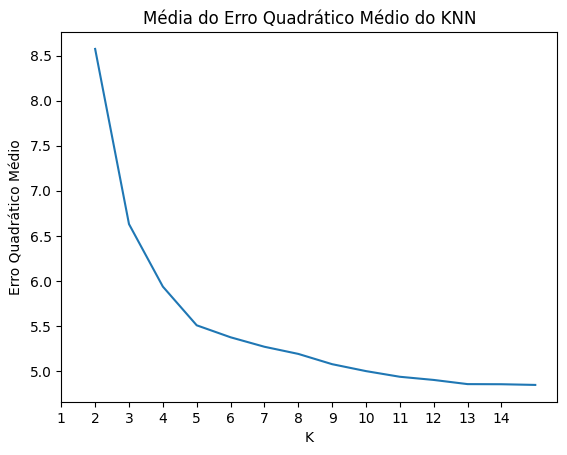

In [ ]:
"""
  Um dos algoritmos que serão testados é o KNN, mas antes de usa-lo é necessário encontrar o valor mais adequado 
  para k. Dessa forma, para cada valor de K utilizamos o método de validação cruzada KFold e armazenamos a média dos
  mse encontrados em cada folder. Então escolhemos o K que possui a menor média. 
"""

#Criando uma cópia normalizada (e sem o Sex) de abalone
abatest = abalone.copy()
sex_col = abatest.pop('Sex')
df_norm = (abatest - abatest.mean()) / abatest.std()

erro_medio = []
valores_k = []

for k in range(1, 15):
    valores_k.append(k)
    erros = []

    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(df_norm)

    for train_index, test_index in splits:
        train_df, test_df = df_norm.iloc[train_index], df_norm.iloc[test_index]

        #Armazenando os valores de Rings antes de substitui-los por NAN
        test_df = pd.DataFrame(test_df)
        true_rings = test_df['Rings']
        test_df['Rings'] = np.nan

        #Separando em variável dependente e independente
        X_train = train_df.drop(['Rings'], axis=1)
        y_train = train_df['Rings']
        X_test = test_df.drop(['Rings'], axis=1)

        #Previsão usando KNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        true_rings = (true_rings * abatest.Rings.std()) + abatest.Rings.mean()
        y_pred = (y_pred * abatest.Rings.std()) + abatest.Rings.mean()

        mse = mean_squared_error(true_rings, y_pred)
        erros.append(mse)
        
    erro_medio.append(np.mean(erros))

melhor_k = erro_medio.index(min(erro_medio))+1
print(f"Melhor quantidade de vizinhos: {melhor_k}\n")
plt.plot(valores_k, erro_medio)
plt.xticks(range(len(erro_medio)), range(1, len(erro_medio)+1))
plt.title("Média do Erro Quadrático Médio do KNN")
plt.xlabel("K")
plt.ylabel("Erro Quadrático Médio")
plt.show()

In [ ]:
def avaliarModelo(df, k):
    """
    Avalia os modelos de KNN e Regressão Linear Multivariada, retornando o mse médio
    e o erro médio em porcentagem de ambos os modelos.
    """

    df_norm = (df - df.mean()) / df.std()

    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(df_norm)

    erro_medio_percent_list_knn = []
    erro_medio_percent_list_reg = []
    mse_list_knn = []
    mse_list_reg = []

    for train_index, test_index in splits:
        train_df, test_df = df_norm.iloc[train_index], df_norm.iloc[test_index]

        #Armazenando os valores de Rings antes de substitui-los por NAN
        test_df = pd.DataFrame(test_df)
        true_rings = test_df['Rings']
        test_df['Rings'] = np.nan

        #Separando em variável dependente e independente
        X_train = train_df.drop(['Rings'], axis=1)
        y_train = train_df['Rings']
        X_test = test_df.drop(['Rings'], axis=1)

        #Previsão usando KNN
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)

        #Previsão usando Regressão Linear Multivariada
        regr = LinearRegression()
        regr.fit(X_train, y_train)
        y_pred_reg = regr.predict(X_test)

        #Voltando a medida original de rings
        true_rings = (true_rings * df.Rings.std()) + df.Rings.mean()
        y_pred_knn = (y_pred_knn * df.Rings.std()) + df.Rings.mean()
        y_pred_reg = (y_pred_reg * df.Rings.std()) + df.Rings.mean()

        #Calculando o mse
        mse_knn = mean_squared_error(true_rings, y_pred_knn)
        mse_list_knn.append(mse_knn)
        mse_reg = mean_squared_error(true_rings, y_pred_reg)
        mse_list_reg.append(mse_reg)

        #Erro do valor previsto em relação ao original (em módulo)
        variacao_knn = np.abs(true_rings - y_pred_knn)
        variacao_reg = np.abs(true_rings - y_pred_reg)

        #Porcentagem de erro em relação ao valor original
        erros_em_porcent_knn = (variacao_knn / true_rings)
        erros_em_porcent_reg = (variacao_reg / true_rings)

        #Calculando o erro médio percentual
        mean_error_percent_knn = np.mean(erros_em_porcent_knn)
        erro_medio_percent_list_knn.append(mean_error_percent_knn)
        mean_error_percent_reg = np.mean(erros_em_porcent_reg)
        erro_medio_percent_list_reg.append(mean_error_percent_reg)

    mse_knn_final = np.mean(mse_list_knn)
    erro_percentual_knn = np.mean(erro_medio_percent_list_knn)
    mse_reg_final = np.mean(mse_list_reg)
    erro_percentual_reg = np.mean(erro_medio_percent_list_reg)

    return [mse_knn_final, erro_percentual_knn, mse_reg_final, erro_percentual_reg]


In [ ]:
def printarAvaliacao(df):
    modelo_avaliado = avaliarModelo(df=df, k=melhor_k)
    print("AVALIAÇÃO DO MODELO KNN:")
    print(f"Média de mse: {modelo_avaliado[0]:.4f}")
    print(f"Erro médio percentual: {modelo_avaliado[1]:.4f}\n")
    print("AVALIAÇÃO DO MODELO DE REGRESSÃO LINEAR MULTIVARIADA:")
    print(f"Média de mse: {modelo_avaliado[2]:.4f}")
    print(f"Erro médio percentual: {modelo_avaliado[3]:.4f}")

In [ ]:
"""
  Para a avaliação dos algoritmos utilizamos o MSE, por sua capacidade de medir a proximidade entre os valores previstos e os valores reais. 
  O MSE penaliza de forma mais significativa os erros maiores, permitindo uma avaliação mais precisa do desempenho do modelo. Além disso, para
  uma avaliação mais intuitiva utilizamos também a média do erro em porcentagem.
  Avaliando os modelos depois de retirar a coluna Sex obtivemos um bom desempenho em ambos os modelos utilizados, 
  com uma diferença tão pequena que não é possivél leva-la em consideração na escolha do melhor modelo.
"""
abatest = abalone.copy()
sex_col = abatest.pop('Sex')
printarAvaliacao(abatest)

AVALIAÇÃO DO MODELO KNN:
Média de mse: 4.8287
Erro médio percentual: 0.1525

AVALIAÇÃO DO MODELO DE REGRESSÃO LINEAR MULTIVARIADA:
Média de mse: 5.0690
Erro médio percentual: 0.1633


In [ ]:
"""
  Tentamos utilizar o método de OneHotEncoder para podermos utilizar a coluna Sex no treinamento dos modelos, de forma
  que esse dado, antes catégórico, tenha o menor viés possivel. Para o KNN, o desempenho teve uma piora (ainda que pequena),
  já para a regressão linear praticamente não surtiu efeito.
"""

abatest = abalone.copy()

sex_values = abalone['Sex'].values.reshape(-1, 1)
sex_col = abatest.pop('Sex')
#Criando 3 colunas binárias, uma para cada valor possível de Sex
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(sex_values)
#Adicionando as novas colunas ao dataframe
sex_columns = ['Sex_M', 'Sex_F', 'Sex_I']
sex_df = pd.DataFrame(onehot_encoded, columns=sex_columns)
abatest = pd.concat([abatest, sex_df], axis=1)

printarAvaliacao(abatest)

AVALIAÇÃO DO MODELO KNN:
Média de mse: 4.9588
Erro médio percentual: 0.1539

AVALIAÇÃO DO MODELO DE REGRESSÃO LINEAR MULTIVARIADA:
Média de mse: 5.0684
Erro médio percentual: 0.1625


<ipython-input-32-2088b29efd5a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(abalone.corr(), fmt=".2f", annot=True, center=0.0)


<Axes: >

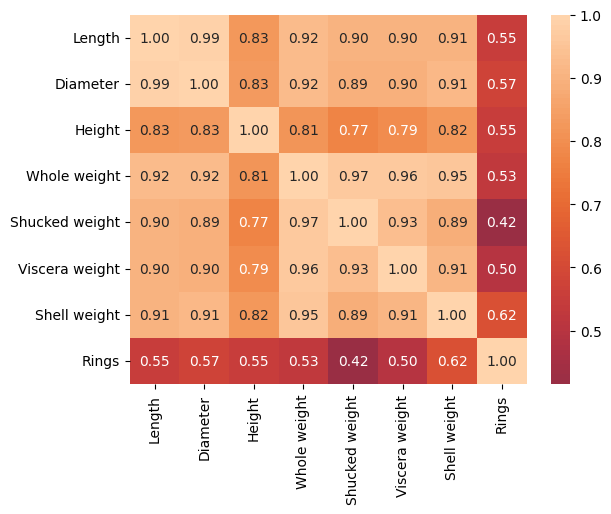

In [ ]:
#Mapa de calor das correlações entre as variáveis.
sns.heatmap(abalone.corr(), fmt=".2f", annot=True, center=0.0)

In [ ]:
"""
    Na busca de diminuir os dados necessários para realizar a previsão de Rings, decidimos tentar reduzir a
  dimensionalidade da base. Analizando os atributos, percebemos eles se dividem em dois sub-grupos: Dimensões e Peso.
    Começando pela dimensão, notamos que Length e Diameter possuem uma alta correlação linear pelo fato de um estar
  diretamente contido no outro, tornando dispensável um dos atributos. Assim, mantivemos Diameter por ter uma
  correlação um pouco maior com Rings.
    Nos atributos relacionados com peso sabemos que Whole Wheight deve ser aproximadamente a soma de todos os outros
  pesos, portanto não é necessário mante-los. 
    Após essa filtragem, permanecemos com Diameter, Height, Whole weight e Rings. 
"""

colunas_filtradas = ['Diameter', 'Whole weight', 'Height', 'Rings']
abatest = abalone.copy()
novo_dataframe = abatest[colunas_filtradas]
printarAvaliacao(novo_dataframe)

AVALIAÇÃO DO MODELO KNN:
Média de mse: 6.4946
Erro médio percentual: 0.1799

AVALIAÇÃO DO MODELO DE REGRESSÃO LINEAR MULTIVARIADA:
Média de mse: 6.8910
Erro médio percentual: 0.1839


In [ ]:
"""
  A redução de dimensionalidade causou uma leve redução da precisão do modelo. Em contrapartida, além de diminuirmos
  o trabalho manual de coleta das informações e o custo computacional de treinamento do modelo de previsão, os atributos 
  necessários não necessitam da morte do animal, tornandoa abordagem em geral mais sustentável.
"""

In [ ]:
"""
  Depois de analisar de várias formas os dois modelos (KNN e Regressão Linear Multivariada), não conseguimos escolher um modelo baseado apenas nas
  avaliações dos modelos, dessa forma, decidimos optar pelo modelo mais de mais fácil explicação, sendo este a Regressão Linear Multivariada. 
  Com ela podemos ter uma melhor visualisação (utilizando um mapa de calor, por exemplo) da influência de cada característica na variável Rings, além 
  de conseguirmos parametrizar essa influência em uma reta que será usada para as previsões. O erro esperado para o rings previsto nesse modelo é de
  aproximadamente 20% em relação ao numero real.
"""

In [ ]:
def retaRegressao(df):
    """
    Avalia o modelo de Regressão Linear Multivariada, retornando os coeficientes médios.
    """

    df_norm = (df - df.mean()) / df.std()

    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(df_norm)

    coef_list_reg = []

    for train_index, test_index in splits:
        train_df, test_df = df_norm.iloc[train_index], df_norm.iloc[test_index]

        #Separando em variável dependente e independente
        X_train = train_df.drop(['Rings'], axis=1)
        y_train = train_df['Rings']
        X_test = test_df.drop(['Rings'], axis=1)

        #Previsão usando Regressão Linear Multivariada
        regr = LinearRegression()
        regr.fit(X_train, y_train)

        #Coeficientes da reta de regressão
        coef_list_reg.append(list(regr.coef_) + [regr.intercept_])

    #Coeficientes médios
    avg_coef_reg = np.mean(coef_list_reg, axis=0)

    return avg_coef_reg



def obterEquacaoReta(coeficientes, columns):
    """
    Retorna o texto com a equação da reta.
    """

    equation = "y = "
    for i, coef in enumerate(coeficientes[:-1]):
        equation += f"{coef:.2f}*{columns[i]} + "
    
    #Adiciona o coeficiente linear
    equation += f"{coeficientes[-1]:.4f}"  
    
    return equation

In [ ]:
"""
  Obtendo a reta de regressão usando apensas as colunas filtradas.
"""
colunas_filtradas = ['Diameter', 'Whole weight', 'Height', 'Rings']
abalone = abalone[colunas_filtradas]
coeficientes = retaRegressao(abalone)
print(obterEquacaoReta(coeficientes, colunas_filtradas))

y = 0.40*Diameter + -0.07*Whole weight + 0.28*Height + 0.0002


In [ ]:
def preverRings(Diameter, WholeWeight, Height, coeficientes, df):
    """
    Prever o valor de Rings com base nos coeficientes obtidos da regressão linear multivariada,
    retornando o valor na medida original.
    """

    #Aplicar a transformação nos dados de entrada
    Diameter_norm = (Diameter - df['Diameter'].mean()) / df['Diameter'].std()
    WholeWeight_norm = (WholeWeight - df['Whole weight'].mean()) / df['Whole weight'].std()
    Height_norm = (Height - df['Height'].mean()) / df['Height'].std()

    #Calcular a previsão usando os coeficientes normalizados
    Rings_norm = coeficientes[0] * Diameter_norm + coeficientes[1] * WholeWeight_norm + coeficientes[2] * Height_norm

    #Desfazer a transformação para obter o valor na medida original
    Rings = (Rings_norm * df['Rings'].std()) + df['Rings'].mean()

    return Rings

In [ ]:
"""
  Testando a previsão usando o modelo escolhido.
"""

indice = abalone.sample().index[0]
dados = abalone.loc[indice, ['Diameter', 'Whole weight', 'Height']]
previsao = preverRings(dados['Diameter'], dados['Whole weight'], dados['Height'], coeficientes, abalone)

print("Real:", abalone.loc[indice, "Rings"])
print("Previsto:", previsao.round(2))

Real: 12.0
Previsto: 12.38
